In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt

In [13]:

# 1. Load merged dataset
file_path = 'merged_ghg_data_with_SA_003.nc'
ds = xr.open_dataset(file_path)

# 2. Extract data: Use all variables and select grid point near Manchester
manchester_lat = 53.4808
manchester_lon = 360 - 2.2426  # Approximately 357.7574 in 0-360 format

variables = ['TREFMXAV_U', 'FLNS', 'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT', 'VBOT', 'SA_Emissions']
data_dict = {}

for var in variables:
    if set(['lat', 'lon']).issubset(ds[var].dims):
        data_dict[var] = ds[var].sel(lat=manchester_lat, lon=manchester_lon, method="nearest").to_series()
    else:
        data_dict[var] = ds[var].to_series()

# Combine into DataFrame with time index
df = pd.DataFrame(data_dict).reset_index()

# 3. Convert time column: Handle cftime.DatetimeNoLeap if present
if isinstance(df['time'].iloc[0], cftime.DatetimeNoLeap):
    df['time'] = df['time'].apply(lambda x: pd.Timestamp(x.strftime("%Y-%m-%d")))
df = df.sort_values('time').reset_index(drop=True)

# 4. Split into training and test sets
train_df = df[(df['time'] >= '2006-01-01') & (df['time'] < '2024-09-30')]
test_df = df[(df['time'] >= '2024-09-30') & (df['time'] <= '2080-12-31')]

# 5. Normalize data using MinMax scaling
features = variables
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

train_scaled_df = pd.DataFrame(train_scaled, columns=features, index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=features, index=test_df.index)

# 6. Create time series sequences
def create_sequences(data, seq_length, target_column):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length][target_column])
    return np.array(X), np.array(y)

seq_length = 1
X_train, y_train = create_sequences(train_scaled_df, seq_length, target_column='TREFMXAV_U')
X_test, y_test = create_sequences(test_scaled_df, seq_length, target_column='TREFMXAV_U')

# 7. Build multivariate LSTM model
model = Sequential()

# First LSTM layer with return sequences
model.add(LSTM(128, activation='tanh', return_sequences=True, 
              input_shape=(seq_length, len(features)),
              kernel_regularizer='l2'))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(128, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))

# Intermediate dense layer
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# 8. Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# 9. Make predictions and inverse scaling
predictions = model.predict(X_test)

# Inverse scaling for predictions
target_index = features.index('TREFMXAV_U')
target_min = scaler.data_min_[target_index]
target_max = scaler.data_max_[target_index]
predictions_inv = predictions * (target_max - target_min) + target_min

# Get true values from original test data
true_values = test_df['TREFMXAV_U'].values[seq_length:]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                12200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12,251
Trainable params: 12,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
214/214 [==============================] - 4s 8ms/step - loss: 0.0270 - val_loss: 0.0138
Epoch 2/50
214/214 [==============================] - 1s 6ms/step - loss: 0.0045 - val_loss: 0.0076
Epoch 3/50
214/214 [==============================] - 1s 6ms/step - loss: 0.0043 - val_loss: 0.0064
Epoch 4/50
214/214 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0055
Epoch 5/50
214/214 [==========================


Evaluation Metrics:
MAE: 1.515
MSE: 3.774
RMSE: 1.943
R² Score: 0.869
MAPE: 2.03%


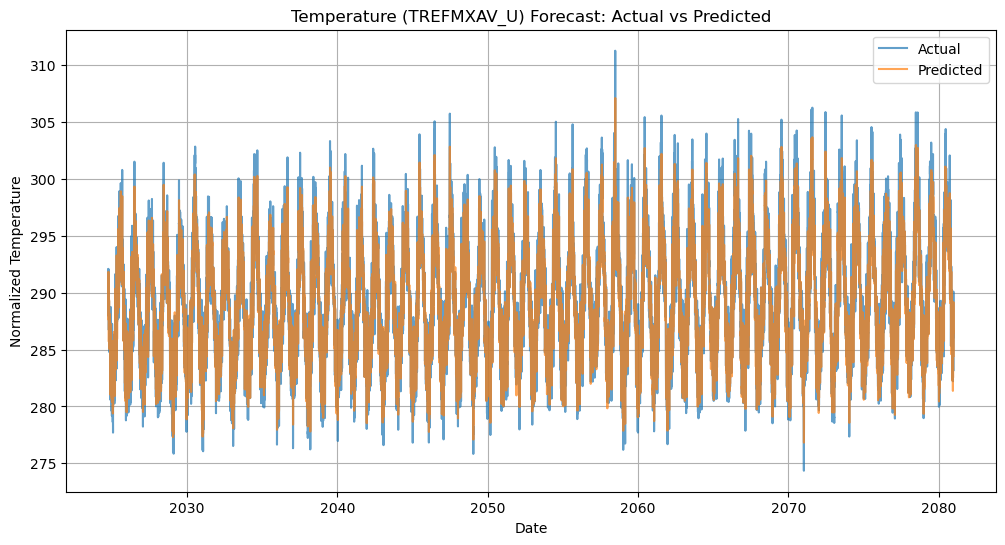

In [14]:
# 10. Calculate evaluation metrics
mae = mean_absolute_error(true_values, predictions_inv)
mse = mean_squared_error(true_values, predictions_inv)
rmse = np.sqrt(mse)
r2 = r2_score(true_values, predictions_inv)
mape = np.mean(np.abs((true_values - predictions_inv) / true_values)) * 100

print("\nEvaluation Metrics:")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")

# 11. Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(test_df['time'].values[seq_length:], true_values, label='Actual', alpha=0.7)
plt.plot(test_df['time'].values[seq_length:], predictions_inv, label='Predicted', alpha=0.7)
plt.title('Temperature (TREFMXAV_U) Forecast: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Normalized Temperature')
plt.legend()
plt.grid(True)
plt.show()


Linear Regression Performance:
MAE: 1.535
RMSE: 1.964
R²: 0.866

Random Forest Performance:
MAE: 1.535
RMSE: 1.991
R²: 0.863

Support Vector Regression Performance:
MAE: 4.714
RMSE: 6.058
R²: -0.272


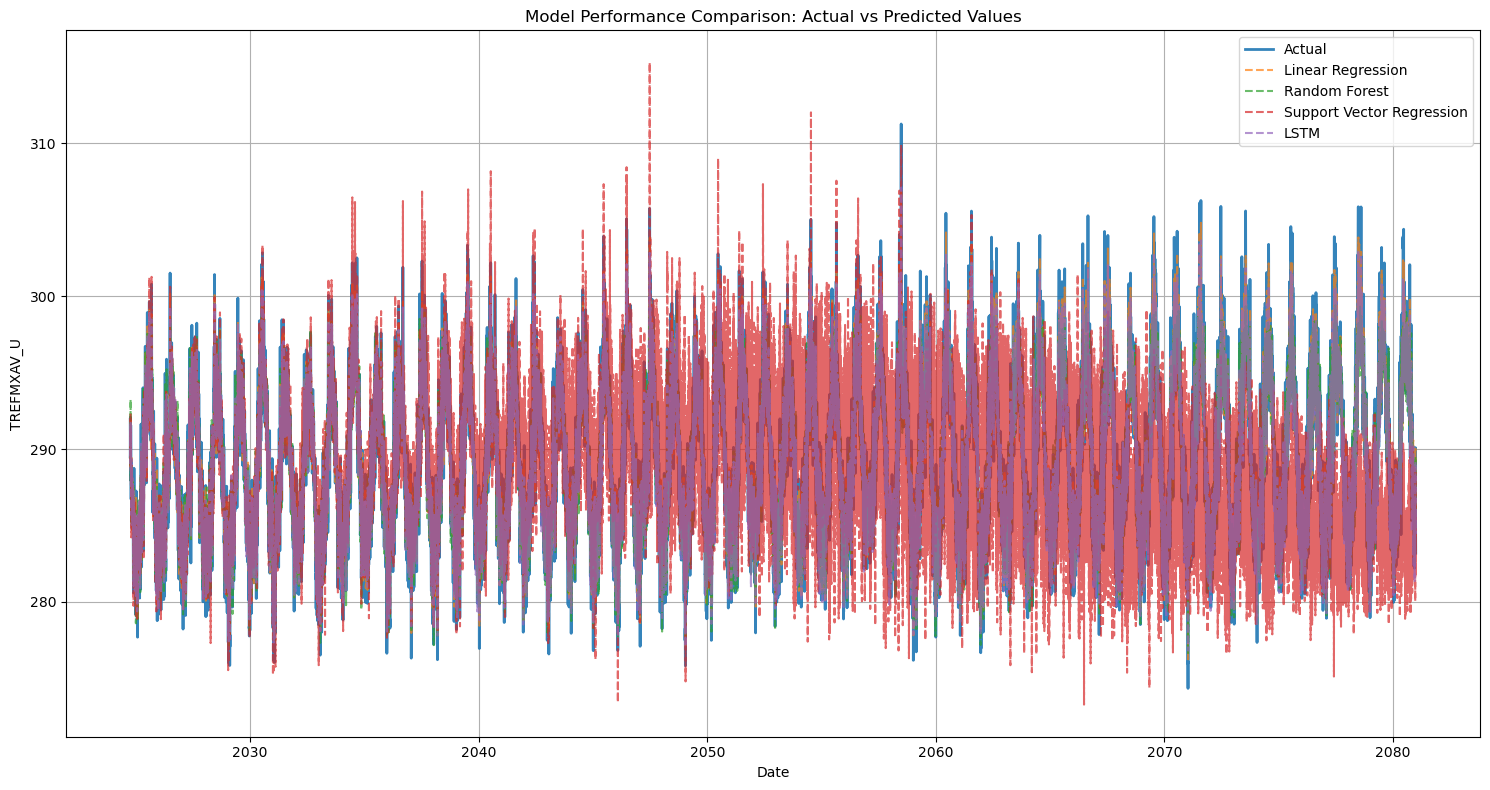


Model Performance Comparison:
                             MAE   RMSE     R2
Linear Regression          1.535  1.964  0.866
Random Forest              1.535  1.991  0.863
Support Vector Regression  4.714  6.058 -0.272
LSTM                       1.515  1.943  0.869


In [15]:
# --- Existing LSTM code above ---

# 10. Add additional regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Reshape data for traditional ML models (flatten time steps)
def reshape_features(X):
    return X.reshape(X.shape[0], -1)  # Flatten time steps and features

X_train_flat = reshape_features(X_train)
X_test_flat = reshape_features(X_test)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regression": SVR(kernel='rbf', C=100, epsilon=0.1)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Training
    model.fit(X_train_flat, y_train)
    
    # Prediction
    y_pred = model.predict(X_test_flat)
    
    # Inverse scaling
    y_pred_inv = y_pred * (target_max - target_min) + target_min
    
    # Calculate metrics
    metrics = {
        "MAE": mean_absolute_error(true_values, y_pred_inv),
        "RMSE": np.sqrt(mean_squared_error(true_values, y_pred_inv)),
        "R2": r2_score(true_values, y_pred_inv),
        "Predictions": y_pred_inv
    }
    
    results[name] = metrics
    print(f"\n{name} Performance:")
    print(f"MAE: {metrics['MAE']:.3f}")
    print(f"RMSE: {metrics['RMSE']:.3f}")
    print(f"R²: {metrics['R2']:.3f}")

# Add LSTM results to comparison
results["LSTM"] = {
    "MAE": mean_absolute_error(true_values, predictions_inv),
    "RMSE": np.sqrt(mean_squared_error(true_values, predictions_inv)),
    "R2": r2_score(true_values, predictions_inv),
    "Predictions": predictions_inv.flatten()
}

# 11. Comparative visualization
plt.figure(figsize=(15, 8))

# Plot true values
plt.plot(test_df['time'].values[seq_length:], true_values, 
         label='Actual', linewidth=2, alpha=0.9)

# Plot predictions
for model_name, metrics in results.items():
    plt.plot(test_df['time'].values[seq_length:], metrics["Predictions"],
             alpha=0.7, linestyle='--', label=f'{model_name}')

plt.title('Model Performance Comparison: Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('TREFMXAV_U')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 12. Metric comparison table
comparison_df = pd.DataFrame({
    model: {metric: values[metric] for metric in ['MAE', 'RMSE', 'R2']} 
    for model, values in results.items()
}).T

print("\nModel Performance Comparison:")
print(comparison_df.round(3))

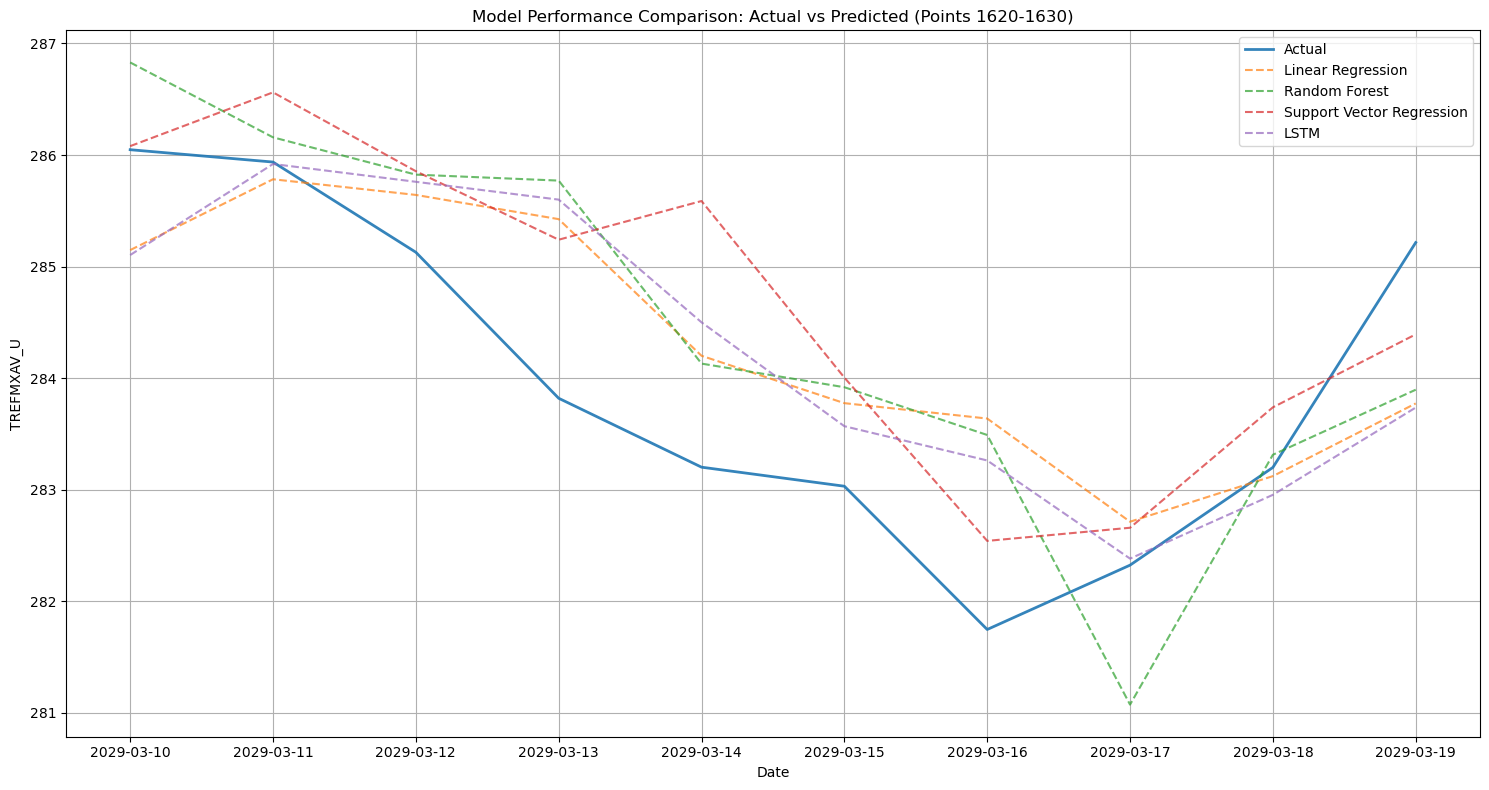

In [16]:
# Set start and end indices for slicing (example: first 200 points)
start_index = 1620
end_index = 1630

plt.figure(figsize=(15, 8))

# Data slicing --------------------------------------------------
# Timestamps (ensure index alignment)
sliced_time = test_df['time'].values[seq_length:][start_index:end_index]
# True values
sliced_true = true_values[start_index:end_index]

# Plot true values
plt.plot(sliced_time, sliced_true, 
         label='Actual', linewidth=2, alpha=0.9)

# Plot model predictions
for model_name, metrics in results.items():
    sliced_pred = metrics["Predictions"][start_index:end_index]  # Slice predictions
    plt.plot(sliced_time, sliced_pred,
             alpha=0.7, linestyle='--', label=f'{model_name}')

# Configure plot appearance
plt.title(f'Model Performance Comparison: Actual vs Predicted (Points {start_index}-{end_index})')
plt.xlabel('Date')
plt.ylabel('TREFMXAV_U')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
import xarray as xr
print(xr.show_versions())


INSTALLED VERSIONS
------------------
commit: None
python: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:39:05) [MSC v.1929 64 bit (AMD64)]
python-bits: 64
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
byteorder: little
LC_ALL: None
LANG: None
LOCALE: ('Chinese (Simplified)_China', '936')
libhdf5: 1.14.5
libnetcdf: 4.8.1

xarray: 2023.6.0
pandas: 2.2.3
numpy: 1.26.4
scipy: 1.13.1
netCDF4: 1.6.2
pydap: None
h5netcdf: None
h5py: 3.12.1
Nio: None
zarr: None
cftime: 1.6.4
nc_time_axis: None
PseudoNetCDF: None
iris: None
bottleneck: 1.4.2
dask: None
distributed: None
matplotlib: 3.9.2
cartopy: None
seaborn: 0.13.2
numbagg: None
fsspec: None
cupy: None
pint: None
sparse: None
flox: None
numpy_groupies: None
setuptools: 75.8.0
pip: 25.0
conda: None
pytest: None
mypy: None
IPython: 8.15.0
sphinx: None
None


C:\Users\Alienware\anaconda3\envs\EART\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
